# 第9章: RNN, CNN

In [2]:
PATH = "./app"

In [3]:
!sudo wget -P {PATH} https://archive.ics.uci.edu/static/public/359/news+aggregator.zip

--2025-01-15 14:58:29--  https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘./app/news+aggregator.zip.1’

news+aggregator.zip     [<=>                 ]       0  --.-KB/s               ^C


In [ ]:
!unzip {PATH}/news+aggregator.zip -d {PATH}

Archive:  ./app/news+aggregator.zip
  inflating: ./app/2pageSessions.csv  
   creating: ./app/__MACOSX/
  inflating: ./app/__MACOSX/._2pageSessions.csv  
  inflating: ./app/newsCorpora.csv   
  inflating: ./app/__MACOSX/._newsCorpora.csv  
  inflating: ./app/readme.txt        
  inflating: ./app/__MACOSX/._readme.txt  


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel

## 80. ID番号への変換

In [ ]:
def prosess(text):
    text = re.sub(r"\s-*?\s", " ", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]", "", text)

    return text

data = pd.read_csv(f"{PATH}/newsCorpora.csv", sep="\t", header=None)
data.columns = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]

publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
data = data[data["PUBLISHER"].isin(publishers)]

data = data.loc[:, ["CATEGORY", "TITLE"]]

data["TITLE"] = data["TITLE"].map(prosess)

vectorizer = TfidfVectorizer(min_df=0.001)
X = vectorizer.fit_transform(data["TITLE"])
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
X_df = pd.concat([data["CATEGORY"], X_df], axis=1)

data = data.sample(frac=1, random_state=42)

train, test_valid = train_test_split(data, test_size=0.2, random_state=1, stratify=data["CATEGORY"])
test, valid = train_test_split(test_valid, test_size=0.5, random_state=1, stratify=test_valid["CATEGORY"])

train.to_csv(f"{PATH}/train.txt", sep="\t", index=False)
test.to_csv(f"{PATH}/test.txt", sep="\t", index=False)
valid.to_csv(f"{PATH}/valid.txt", sep="\t", index=False)

print("train:")
print(train["CATEGORY"].value_counts())
print("\ntest:")
print(test["CATEGORY"].value_counts())
print("\nvalid:")
print(valid["CATEGORY"].value_counts())

train:
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64

test:
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64

valid:
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64


In [ ]:
words = []
for text in train['TITLE']:
    for word in text.rstrip().split():
        words.append(word)
c = Counter(words)
word2id = {}
for i, cnt in enumerate(c.most_common()):
    if cnt[1] > 1:
        word2id[cnt[0]] = i + 1
for i, cnt in enumerate(word2id.items()):
    if i >= 10:
        break
    print(cnt[0], cnt[1])

def tokenizer(text):
    words = text.rstrip().split()
    return [word2id.get(word, 0) for word in words]

sample = train.iloc[0, 1]
print(sample)
print(tokenizer(sample))

to 1
in 2
UPDATE 3
on 4
US 5
as 6
for 7
The 8
of 9
1 10
CORRECTED IMF still sees advantage for too important to fail banks
[123, 548, 447, 267, 5220, 7, 1046, 0, 1, 5221, 381]


## 81. RNNによる予測

In [ ]:
class RNN(nn.Module):
	def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1):
		super().__init__()
		self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
		self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x, h0=None):
		x = self.emb(x)
		y, h = self.rnn(x, h0)
		y = y[:, -1, :]
		y = self.fc(y)
		return y

VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
print(model)

RNN(
  (emb): Embedding(9609, 300, padding_idx=9608)
  (rnn): RNN(300, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)


In [7]:
def EncoderNN(sign):
    category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
    try:
        code = category_dict[sign]
        return code
    except:
        raise ValueError("Invalid sign: {}".format(sign))

def TorchData(data):
	df = pd.read_table(f"{PATH}/{data}.txt")

	df["CATEGORY"] = df["CATEGORY"].map(EncoderNN)

	return Dataset(df, df["CATEGORY"])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X['TITLE']
        self.y = y
    
    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)
    
    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        inputs = torch.tensor(tokenizer(self.X[idx]))
        return inputs, self.y[idx]

train_dataset = TorchData("train")
test_dataset = TorchData("test")
valid_dataset = TorchData("valid")

## 82. 確率的勾配降下法による学習

epoch: 1 / 10


100%|██████████| 10672/10672 [00:59<00:00, 179.91it/s]


train Loss: 1.0949 Acc: 0.5674


100%|██████████| 1334/1334 [00:01<00:00, 759.23it/s]


valid Loss: 0.9172 Acc: 0.6949
--------------------------------------------------
epoch: 2 / 10


100%|██████████| 10672/10672 [00:59<00:00, 178.41it/s]


train Loss: 0.8530 Acc: 0.7034


100%|██████████| 1334/1334 [00:01<00:00, 825.33it/s]


valid Loss: 0.8715 Acc: 0.6927
--------------------------------------------------
epoch: 3 / 10


100%|██████████| 10672/10672 [00:59<00:00, 177.93it/s]


train Loss: 0.7299 Acc: 0.7468


100%|██████████| 1334/1334 [00:01<00:00, 778.11it/s]


valid Loss: 0.7984 Acc: 0.7301
--------------------------------------------------
epoch: 4 / 10


100%|██████████| 10672/10672 [00:59<00:00, 179.50it/s]


train Loss: 0.6255 Acc: 0.7793


100%|██████████| 1334/1334 [00:01<00:00, 768.22it/s]


valid Loss: 0.8262 Acc: 0.7256
--------------------------------------------------
epoch: 5 / 10


100%|██████████| 10672/10672 [01:00<00:00, 175.54it/s]


train Loss: 0.5206 Acc: 0.8132


100%|██████████| 1334/1334 [00:01<00:00, 770.50it/s]


valid Loss: 0.8026 Acc: 0.7369
--------------------------------------------------
epoch: 6 / 10


100%|██████████| 10672/10672 [01:02<00:00, 171.97it/s]


train Loss: 0.4639 Acc: 0.8331


100%|██████████| 1334/1334 [00:01<00:00, 755.83it/s]


valid Loss: 1.0695 Acc: 0.6807
--------------------------------------------------
epoch: 7 / 10


100%|██████████| 10672/10672 [01:01<00:00, 173.33it/s]


train Loss: 0.4540 Acc: 0.8370


100%|██████████| 1334/1334 [00:01<00:00, 708.72it/s]


valid Loss: 0.9262 Acc: 0.6777
--------------------------------------------------
epoch: 8 / 10


100%|██████████| 10672/10672 [01:01<00:00, 172.31it/s]


train Loss: 0.4026 Acc: 0.8519


100%|██████████| 1334/1334 [00:01<00:00, 746.15it/s]


valid Loss: 0.8956 Acc: 0.7001
--------------------------------------------------
epoch: 9 / 10


100%|██████████| 10672/10672 [01:01<00:00, 172.74it/s]


train Loss: 0.3471 Acc: 0.8710


100%|██████████| 1334/1334 [00:01<00:00, 764.79it/s]


valid Loss: 0.9307 Acc: 0.7354
--------------------------------------------------
epoch: 10 / 10


100%|██████████| 10672/10672 [01:02<00:00, 171.54it/s]


train Loss: 0.3399 Acc: 0.8756


100%|██████████| 1334/1334 [00:01<00:00, 702.29it/s]


valid Loss: 0.9302 Acc: 0.7211
--------------------------------------------------


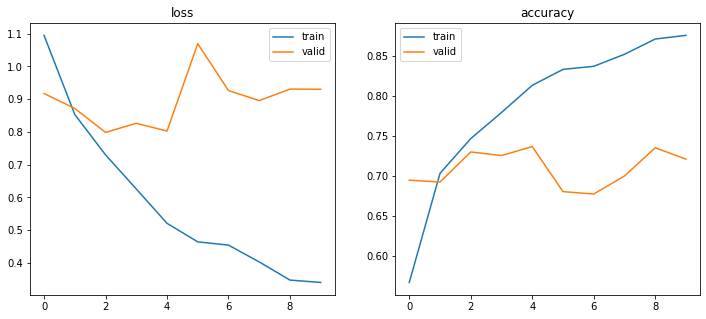

In [42]:
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

DL_train = DataLoader(train_dataset, batch_size=1, shuffle=True)
DL_test = DataLoader(test_dataset, batch_size=1, shuffle=False)
DL_valid = DataLoader(valid_dataset, batch_size=1, shuffle=False)
DL_dict = {"train": DL_train, "test": DL_test, "valid": DL_valid}

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

epoch = 10
for ep in range(epoch):
	print(f"epoch: {ep+1} / {epoch}")
	for phase in ["train", "valid"]:
		epoch_loss = 0.0
		epoch_corrects = 0

		for X, Y in tqdm(DL_dict[phase]):
			optimizer.zero_grad()
			Y_pred = model(X)
			CEloss = loss(Y_pred, Y)
			_, preds = torch.max(Y_pred, 1)
			
			if phase == "train":
				CEloss.backward()
				optimizer.step()

			epoch_loss += CEloss.item() * X.size(0)
			epoch_corrects += torch.sum(preds == Y.data)

		epoch_loss = epoch_loss / len(DL_dict[phase].dataset)
		epoch_acc = epoch_corrects.double() / len(DL_dict[phase].dataset)
		if phase == 'train':
			train_loss.append(epoch_loss)
			train_acc.append(epoch_acc)
		else:
			valid_loss.append(epoch_loss)
			valid_acc.append(epoch_acc)
		print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
		
	print("-"*50)
		
ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()

## 83. ミニバッチ化・GPU上での学習

In [8]:
def train_model(model, DL_dict, loss, optimizer, epoch):

	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	print(torch.cuda.get_device_name())
	print("使用デバイス:", device)

	model.to(device)

	train_loss = []
	train_acc = []
	valid_loss = []
	valid_acc = []

	for ep in range(epoch):
		print(f"epoch: {ep+1} / {epoch}")
		for phase in ["train", "valid"]:
			epoch_loss = 0.0
			epoch_corrects = 0

			for X, Y in DL_dict[phase]:
				X = X.to(device)
				Y = Y.to(device)
				optimizer.zero_grad()
				Y_pred = model(X)
				CEloss = loss(Y_pred, Y)
				_, preds = torch.max(Y_pred, 1)
				
				if phase == "train":
					CEloss.backward()
					optimizer.step()

				epoch_loss += CEloss.item() * X.size(0)
				epoch_corrects += torch.sum(preds == Y.data)

			epoch_loss = epoch_loss / len(DL_dict[phase].dataset)
			epoch_acc = epoch_corrects.double() / len(DL_dict[phase].dataset)
			if phase == 'train':
				train_loss.append(epoch_loss)
				train_acc.append(epoch_acc.cpu())
			else:
				valid_loss.append(epoch_loss)
				valid_acc.append(epoch_acc.cpu())
			print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
			
		print("-"*50)

	return train_loss, train_acc, valid_loss, valid_acc

NVIDIA GeForce RTX 2070
使用デバイス: cuda:0
epoch: 1 / 30
train Loss: 1.2016 Acc: 0.4371
valid Loss: 1.1668 Acc: 0.4318
--------------------------------------------------
epoch: 2 / 30
train Loss: 1.1613 Acc: 0.4519
valid Loss: 1.1634 Acc: 0.4400
--------------------------------------------------
epoch: 3 / 30
train Loss: 1.1588 Acc: 0.4592
valid Loss: 1.1605 Acc: 0.4483
--------------------------------------------------
epoch: 4 / 30
train Loss: 1.1495 Acc: 0.4726
valid Loss: 1.1581 Acc: 0.4528
--------------------------------------------------
epoch: 5 / 30
train Loss: 1.1448 Acc: 0.4813
valid Loss: 1.1556 Acc: 0.4595
--------------------------------------------------
epoch: 6 / 30
train Loss: 1.1335 Acc: 0.5000
valid Loss: 1.1509 Acc: 0.4760
--------------------------------------------------
epoch: 7 / 30
train Loss: 1.1171 Acc: 0.5194
valid Loss: 1.1348 Acc: 0.5015
--------------------------------------------------
epoch: 8 / 30
train Loss: 1.0925 Acc: 0.5486
valid Loss: 1.1105 Acc: 0.5

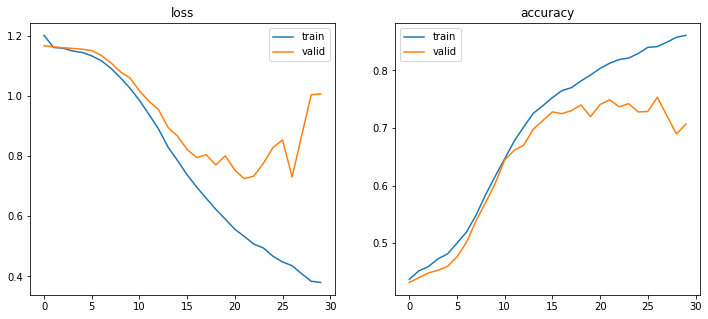

In [43]:
def collate_fn(batch):
    sequences = [x[0] for x in batch]
    labels = torch.LongTensor([x[1] for x in batch])
    x = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PADDING_IDX)
    return x, labels

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)

batch_size = 32
DL_train = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
DL_test = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
DL_valid = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
DL_dict = {"train": DL_train, "test": DL_test, "valid": DL_valid}

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

epoch = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(model, DL_dict, loss, optimizer, epoch)

ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()

## 84. 単語ベクトルの導入

In [ ]:
file = f'{PATH}/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.1, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9267 / 9609
torch.Size([9609, 300])


NVIDIA GeForce RTX 2070
使用デバイス: cuda:0
epoch: 1 / 30
train Loss: 1.2042 Acc: 0.4269
valid Loss: 1.1622 Acc: 0.4415
--------------------------------------------------
epoch: 2 / 30
train Loss: 1.1620 Acc: 0.4463
valid Loss: 1.1633 Acc: 0.4438
--------------------------------------------------
epoch: 3 / 30
train Loss: 1.1583 Acc: 0.4500
valid Loss: 1.1595 Acc: 0.4490
--------------------------------------------------
epoch: 4 / 30
train Loss: 1.1570 Acc: 0.4540
valid Loss: 1.1580 Acc: 0.4483
--------------------------------------------------
epoch: 5 / 30
train Loss: 1.1510 Acc: 0.4643
valid Loss: 1.1578 Acc: 0.4543
--------------------------------------------------
epoch: 6 / 30
train Loss: 1.1481 Acc: 0.4707
valid Loss: 1.1571 Acc: 0.4543
--------------------------------------------------
epoch: 7 / 30
train Loss: 1.1455 Acc: 0.4784
valid Loss: 1.1546 Acc: 0.4625
--------------------------------------------------
epoch: 8 / 30
train Loss: 1.1426 Acc: 0.4833
valid Loss: 1.1523 Acc: 0.4

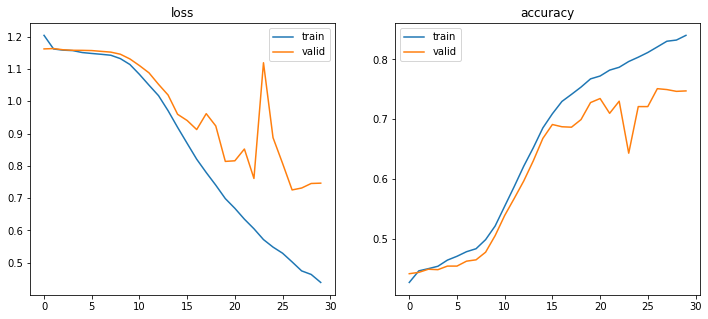

In [ ]:
class RNN(nn.Module):
	def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1, emb_weights=None):
		super().__init__()
		if emb_weights != None:
			self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
		else:
			self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
		self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x, h0=None):
		x = self.emb(x)
		y, h = self.rnn(x, h0)
		y = y[:, -1, :]
		y = self.fc(y)
		return y

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

train_loss, train_acc, valid_loss, valid_acc = train_model(model, DL_dict, loss, optimizer, epoch=30)

ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()

## 85. 双方向RNN・多層化

NVIDIA GeForce RTX 2070
使用デバイス: cuda:0
epoch: 1 / 30
train Loss: 1.2101 Acc: 0.4155
valid Loss: 1.1697 Acc: 0.4363
--------------------------------------------------
epoch: 2 / 30
train Loss: 1.1666 Acc: 0.4434
valid Loss: 1.1669 Acc: 0.4430
--------------------------------------------------
epoch: 3 / 30
train Loss: 1.1629 Acc: 0.4455
valid Loss: 1.1649 Acc: 0.4453
--------------------------------------------------
epoch: 4 / 30
train Loss: 1.1578 Acc: 0.4558
valid Loss: 1.1637 Acc: 0.4520
--------------------------------------------------
epoch: 5 / 30
train Loss: 1.1541 Acc: 0.4656
valid Loss: 1.1624 Acc: 0.4468
--------------------------------------------------
epoch: 6 / 30
train Loss: 1.1506 Acc: 0.4678
valid Loss: 1.1621 Acc: 0.4528
--------------------------------------------------
epoch: 7 / 30
train Loss: 1.1482 Acc: 0.4743
valid Loss: 1.1603 Acc: 0.4453
--------------------------------------------------
epoch: 8 / 30
train Loss: 1.1422 Acc: 0.4853
valid Loss: 1.1578 Acc: 0.4

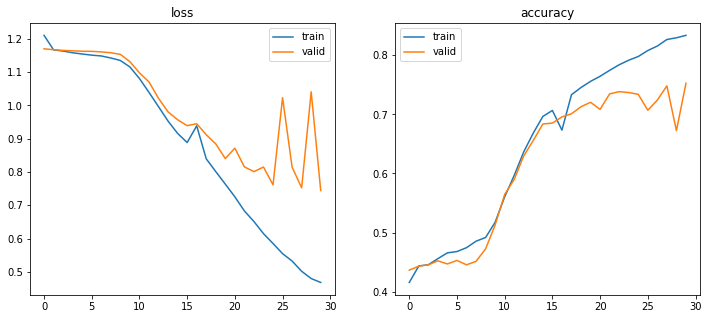

In [47]:
class RNN(nn.Module):
	def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1, emb_weights=None):
		super().__init__()
		if emb_weights != None:
			self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
		else:
			self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
		self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True, bidirectional=True)
		self.fc = nn.Linear(hidden_size * 2, output_size)

	def forward(self, x, h0=None):
		x = self.emb(x)
		y, h = self.rnn(x, h0)
		y = y[:, -1, :]
		y = self.fc(y)
		return y

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 3

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

train_loss, train_acc, valid_loss, valid_acc = train_model(model, DL_dict, loss, optimizer, epoch=30)

ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()

## 86. 畳み込みニューラルネットワーク (CNN)

In [19]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        logits = self.fc(self.drop(max_pool.squeeze(2)))
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

## 87. 確率的勾配降下法によるCNNの学習

NVIDIA GeForce RTX 2070
使用デバイス: cuda:0
epoch: 1 / 30
train Loss: 1.1963 Acc: 0.4214
valid Loss: 1.1627 Acc: 0.4580
--------------------------------------------------
epoch: 2 / 30
train Loss: 1.1517 Acc: 0.4768
valid Loss: 1.1442 Acc: 0.5112
--------------------------------------------------
epoch: 3 / 30
train Loss: 1.1368 Acc: 0.5107
valid Loss: 1.1350 Acc: 0.4910
--------------------------------------------------
epoch: 4 / 30
train Loss: 1.1207 Acc: 0.5344
valid Loss: 1.1119 Acc: 0.5645
--------------------------------------------------
epoch: 5 / 30
train Loss: 1.0966 Acc: 0.5690
valid Loss: 1.0903 Acc: 0.5795
--------------------------------------------------
epoch: 6 / 30
train Loss: 1.0694 Acc: 0.5911
valid Loss: 1.0681 Acc: 0.5832
--------------------------------------------------
epoch: 7 / 30
train Loss: 1.0376 Acc: 0.6157
valid Loss: 1.0293 Acc: 0.6237
--------------------------------------------------
epoch: 8 / 30
train Loss: 1.0045 Acc: 0.6368
valid Loss: 1.0004 Acc: 0.6

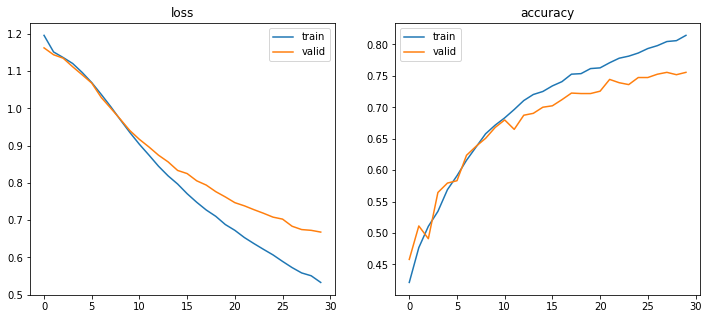

In [20]:
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

epoch = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(model, DL_dict, loss, optimizer, epoch)

ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()

## 88. パラメータチューニング

NVIDIA GeForce RTX 2070
使用デバイス: cuda:0
epoch: 1 / 30
train Loss: 0.8923 Acc: 0.6537
valid Loss: 0.7342 Acc: 0.7256
--------------------------------------------------
epoch: 2 / 30
train Loss: 0.6093 Acc: 0.7786
valid Loss: 0.6955 Acc: 0.7496
--------------------------------------------------
epoch: 3 / 30
train Loss: 0.4827 Acc: 0.8276
valid Loss: 0.6659 Acc: 0.7684
--------------------------------------------------
epoch: 4 / 30
train Loss: 0.3967 Acc: 0.8549
valid Loss: 0.6930 Acc: 0.7691
--------------------------------------------------
epoch: 5 / 30
train Loss: 0.3447 Acc: 0.8737
valid Loss: 0.7150 Acc: 0.7751
--------------------------------------------------
epoch: 6 / 30
train Loss: 0.3161 Acc: 0.8884
valid Loss: 0.6832 Acc: 0.7841
--------------------------------------------------
epoch: 7 / 30
train Loss: 0.2919 Acc: 0.8961
valid Loss: 0.6859 Acc: 0.7894
--------------------------------------------------
epoch: 8 / 30
train Loss: 0.2672 Acc: 0.9056
valid Loss: 0.6861 Acc: 0.8

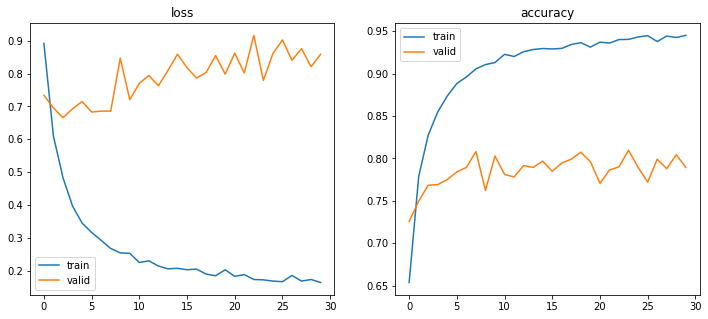

In [22]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.AdamW(params=model.parameters(), lr=0.01)

epoch = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(model, DL_dict, loss, optimizer, epoch)

ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()

## 89. 事前学習済み言語モデルからの転移学習

In [77]:
def BERTData(data):
	df = pd.read_table(f"{PATH}/{data}.txt")

	df["CATEGORY"] = df["CATEGORY"].map(EncoderNN)

	return BERTDataSet(df, df["CATEGORY"])

class BERTDataSet(Dataset):
    
    def __init__(self, X, y):
        self.X = X['TITLE']
        self.y = y
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
       
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        sentence = self.X[idx]
        sentence = str(sentence)
        sentence = " ".join(sentence.split())
        
        bert_sens = self.tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, # [CLS],[SEP]
                                max_length = 20,
								padding = 'max_length',
                                truncation=True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        labels = self.y[idx]
     
        return {'ids': ids, 'mask': mask, 'labels': labels}

train_dataset = BERTData("train")
test_dataset = BERTData("test")
valid_dataset = BERTData("valid")

In [78]:
batch_size = 32
DL_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
DL_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
DL_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
DL_dict = {"train": DL_train, "test": DL_test, "valid": DL_valid}

In [79]:
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, hidden_size, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Sequential(
                                nn.Linear(768, hidden_size),
                                nn.ReLU(),
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, output_size)
                                )

    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask=mask)[-1]
        out = self.fc(self.drop(out))
        return out

In [80]:
def train_model(model, DL_dict, loss, optimizer, epoch):

	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	print(torch.cuda.get_device_name())
	print("使用デバイス:", device)

	model.to(device)

	train_loss = []
	train_acc = []
	valid_loss = []
	valid_acc = []

	for ep in range(epoch):
		print(f"epoch: {ep+1} / {epoch}")
		for phase in ["train", "valid"]:
			epoch_loss = 0.0
			epoch_corrects = 0

			for data in DL_dict[phase]:
				ids = data['ids'].to(device)
				mask = data['mask'].to(device)
				labels = data['labels'].to(device)
				optimizer.zero_grad()
				outputs = model(ids, mask)
				CEloss = loss(outputs, labels)
				_, preds = torch.max(outputs, 1)
				
				if phase == "train":
					CEloss.backward()
					optimizer.step()

				epoch_loss += CEloss.item() * ids.size(0)
				epoch_corrects += torch.sum(preds == labels.data)

			epoch_loss = epoch_loss / len(DL_dict[phase].dataset)
			epoch_acc = epoch_corrects.double() / len(DL_dict[phase].dataset)
			if phase == 'train':
				train_loss.append(epoch_loss)
				train_acc.append(epoch_acc.cpu())
			else:
				valid_loss.append(epoch_loss)
				valid_acc.append(epoch_acc.cpu())
			print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
			
		print("-"*50)

	return train_loss, train_acc, valid_loss, valid_acc

NVIDIA GeForce RTX 2070
使用デバイス: cuda:0
epoch: 1 / 8
train Loss: 0.5497 Acc: 0.8067
valid Loss: 0.3079 Acc: 0.9138
--------------------------------------------------
epoch: 2 / 8
train Loss: 0.2061 Acc: 0.9419
valid Loss: 0.2570 Acc: 0.9288
--------------------------------------------------
epoch: 3 / 8
train Loss: 0.1102 Acc: 0.9714
valid Loss: 0.2612 Acc: 0.9363
--------------------------------------------------
epoch: 4 / 8
train Loss: 0.0619 Acc: 0.9882
valid Loss: 0.2802 Acc: 0.9318
--------------------------------------------------
epoch: 5 / 8
train Loss: 0.0411 Acc: 0.9933
valid Loss: 0.3210 Acc: 0.9168
--------------------------------------------------
epoch: 6 / 8
train Loss: 0.0318 Acc: 0.9950
valid Loss: 0.3035 Acc: 0.9385
--------------------------------------------------
epoch: 7 / 8
train Loss: 0.0217 Acc: 0.9966
valid Loss: 0.2959 Acc: 0.9385
--------------------------------------------------
epoch: 8 / 8
train Loss: 0.0169 Acc: 0.9974
valid Loss: 0.3362 Acc: 0.9295
----

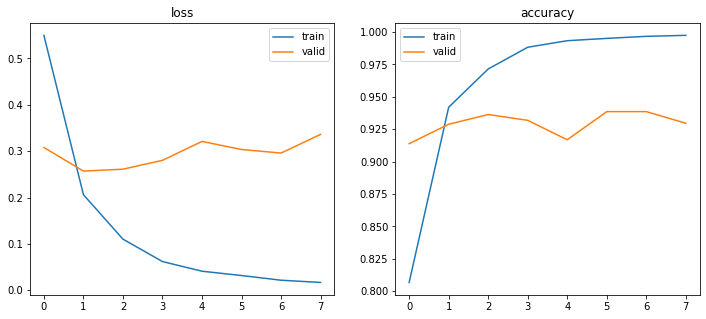

In [81]:
# パラメータの設定
DROP_RATE = 0.2
HIDDEN_SIZE = 256
OUTPUT_SIZE = 4

model = BERTClass(DROP_RATE, HIDDEN_SIZE, OUTPUT_SIZE)

loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

epoch = 8
train_loss, train_acc, valid_loss, valid_acc = train_model(model, DL_dict, loss, optimizer, epoch)

ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()